In [45]:
from torch.utils.data import Dataset, DataLoader, SequentialSampler
from HiSiNet.HiCDatasetClass import HiCDataset,GroupedHiCDataset
from HiSiNet.reference_dictionaries import reference_genomes
from HiSiNet import models
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import sys
import torch.nn.functional as F

import copy 

def return_embeddings(model, dataloader):
    embeddings=None
    labels = np.array([])
    for _, data in enumerate(dataloader):
        input1, label = data
        output1 = model.forward_one(input1)
        if embeddings is None: embeddings=output1.cpu().detach().numpy()
        else: embeddings = np.concatenate((embeddings, output1.cpu().detach().numpy()))
        label = label.type(torch.FloatTensor)
        labels  = np.concatenate((labels, label.cpu().detach().numpy()))
    return embeddings,labels


In [4]:
path=""

In [5]:
model = eval("models.SLeNet")(mask=True)
model.load_state_dict(torch.load(path+"/models/main_datasets/Tcell_differentiation_10kb.ckpt", map_location=torch.device('cpu')))
model.eval()
toyed_model=ToyModel(model)
 
list_of_HiCDatasets =[HiCDataset.load(data_path) for data_path in [path +"/data/tcell_data/CD69posCD4SPWTR1.mlhic",
                                                        path +"/data/tcell_data/CD69posCD4SPWTR2.mlhic",
                                                        path +"/data/tcell_data/CD69negDPWTR1.mlhic", 
                                                        path +"/data/tcell_data/CD69negDPWTR2.mlhic",
                                                        path +"/data/tcell_data/CD69posCD4SPWTR1_test.mlhic",
                                                        path +"/data/tcell_data/CD69posCD4SPWTR2_test.mlhic",
                                                        path +"/data/tcell_data/CD69negDPWTR1_test.mlhic", 
                                                        path +"/data/tcell_data/CD69negDPWTR2_test.mlhic",
                                                        path +"/data/tcell_data/CD69posCD4SPWTR1_validation.mlhic",
                                                        path +"/data/tcell_data/CD69posCD4SPWTR2_validation.mlhic",
                                                        path +"/data/tcell_data/CD69negDPWTR1_validation.mlhic", 
                                                        path +"/data/tcell_data/CD69negDPWTR2_validation.mlhic"]]


In [46]:
dataset=GroupedHiCDataset(list_of_HiCDatasets)
test_sampler = SequentialSampler(dataset)
dataloader_curr = DataLoader(dataset, batch_size=100, sampler = test_sampler)
embeddings, labels = return_embeddings(model, dataloader_curr)


In [169]:
full_list_of_gp={'Chromosome':np.array([]), 'Start':np.array([]),  'End':np.array([])}

for i in list_of_HiCDatasets:
    dict_chroms = i.get_genomic_positions()
    full_list_of_gp['Chromosome']= np.concatenate((full_list_of_gp['Chromosome'],dict_chroms['Chromosome']))
    full_list_of_gp['Start']= np.concatenate((full_list_of_gp['Start'],dict_chroms['Start']))
    full_list_of_gp['End']= np.concatenate((full_list_of_gp['End'],dict_chroms['End']))
    
full_list_of_gp["labels"] = labels

full_list_of_gp["index_name"] = np.arange(0,len(full_list_of_gp["Chromosome"]),1)

[(-0.036499354243278506, -1.6498802182241432e-08),
 (-0.0013588516367599368, -4.607614879914578e-12)]

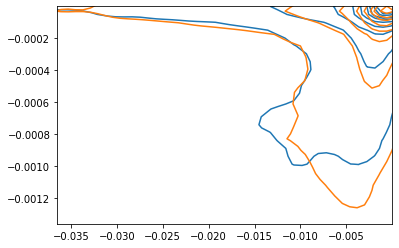

In [215]:
from sklearn.decomposition import PCA
pca_tcells = PCA(embeddings)
comp_id1, comp_id2 = 0, 1 
x = 0.01
g=sns.kdeplot(x=pca_tcells.n_components[:,comp_id1], y=pca_tcells.n_components[:,comp_id2], 
                hue=labels, legend=False)
g.set(xlim=(np.quantile(pca_tcells.n_components[:,comp_id1], x), 
            np.quantile(pca_tcells.n_components[:,comp_id1], 1-x)),
      ylim=(np.quantile(pca_tcells.n_components[:,comp_id2], x), 
            np.quantile(pca_tcells.n_components[:,comp_id2], 1-x)))

In [153]:
import random
import matplotlib.colors as colors

original position:       Chromosome       Start         End  labels  index_name  distances
47141          9  35840000.0  38400000.0     0.0       47141        0.0


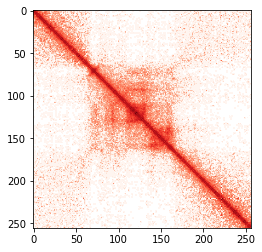

1 closest fit: ('9', 35840000.0)


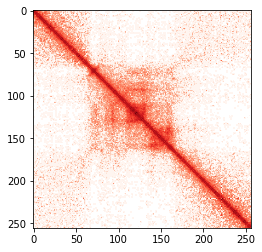

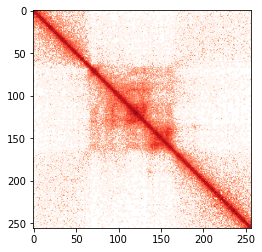

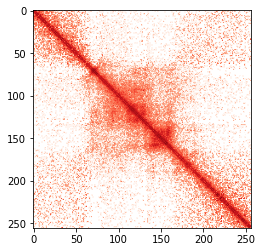

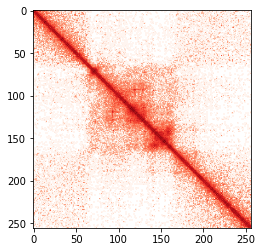

2 closest fit: ('3', 77920000.0)


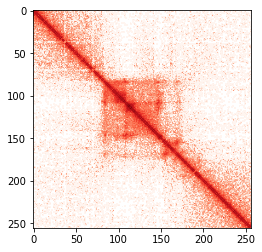

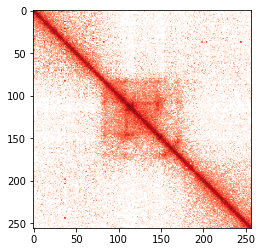

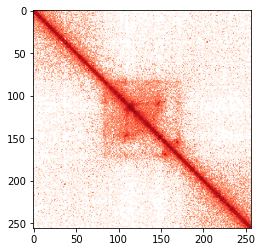

3 closest fit: ('4', 52160000.0)


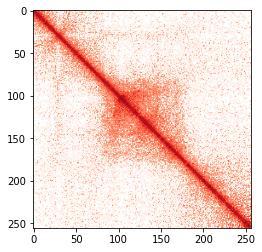

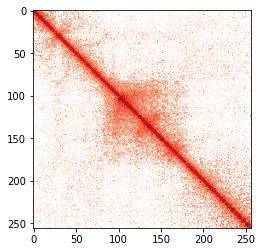

In [205]:
pos=47141#random.randint(0,57285) #3178 #

Genomic_positions["distances"]=np.sum((embeddings - embeddings[pos])*(embeddings - embeddings[pos]),1)
mini = Genomic_positions.sort_values(by="distances", ascending=True ).head(30)
counts_mini = mini.value_counts(["Chromosome","Start"])

print("original position:",Genomic_positions[Genomic_positions.index_name==pos])
plt.imshow(dataset[pos][0][0], cmap="Reds", norm=colors.LogNorm(vmin=0.01, vmax=1))
plt.show()

to_show = 1
for location, _ in pd.DataFrame(counts_mini).iterrows():
    print(to_show,"closest fit:", location)
    for index in mini.index_name[(mini.Chromosome==location[0])&(mini.Start==location[1])]:
        plt.imshow(dataset[index][0][0], cmap="Reds", norm=colors.LogNorm(vmin=0.01, vmax=1))
        plt.show()
    to_show+=1
    if to_show == 4: break
    